<a href="https://colab.research.google.com/github/williamweem/one-notebook-ds-project/blob/master/dicoding-rock-paper-scissor-classifier/Dicoding_ML_Final_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import time
from google.colab import files
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!wget --no-check-certificate  \
 https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
 -O /tmp/rockpaperscissors.zip


local_zip = "/tmp/rockpaperscissors.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-05-25 02:15:03--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  5.37MB/s    in 64s     

2020-05-25 02:16:07 (4.84 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [0]:
def to_label(value):
    if all(value==[1.,0.,0.]):
        return 'paper'
    elif all(value==[0.,1.,0.]):
        return "rock"
    else:
        return 'scissors'

def plots(ims, figsize=(24,12), rows=4, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history.history['accuracy'])
    plt.plot(history.history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history.history['loss'])
    plt.plot(history.history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

In [0]:
batch_size = 20
nbr_epochs = 10
classnames = ['paper', 'rock', 'scissors']
root_dir = '/tmp/rockpaperscissors'

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = "nearest",
    validation_split = 0.2
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = "nearest"
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    root_dir,
    target_size = (200,200),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = True,
    subset = "training",
    classes = classnames)

val_generator = train_datagen.flow_from_directory(
    root_dir,
    target_size = (200,200),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=True,
    subset="validation",
    classes = classnames)

test_generator = test_datagen.flow_from_directory(
    root_dir,
    target_size = (200,200),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=True,
    classes = classnames)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Found 2188 images belonging to 3 classes.


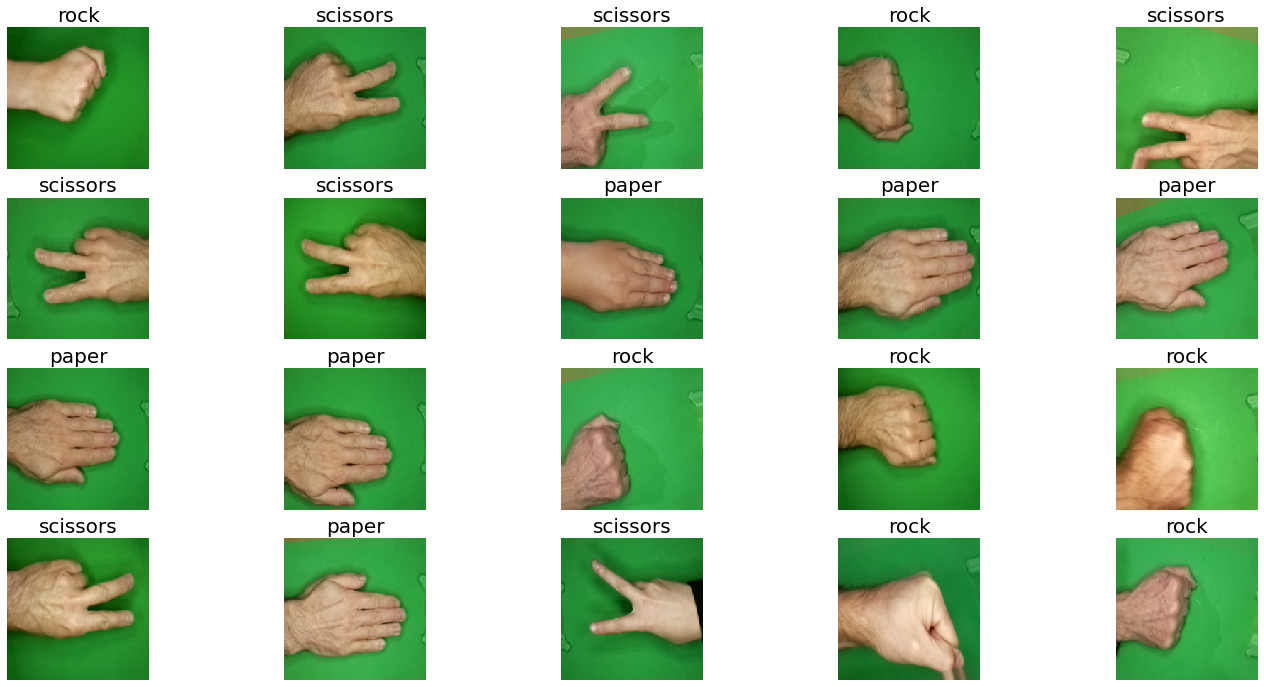

In [19]:
imgs, labels = next(train_generator)
imgs_label = list(map(to_label,labels))
plots(imgs, titles=imgs_label)

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(3, activation="softmax")
])

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0

In [11]:
ts = time.time()

best_model_filename = 'weights.h5'   
best_model = ModelCheckpoint(best_model_filename, monitor='val_accuracy', verbose=1, save_best_only=True)

model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples//batch_size,
    epochs = nbr_epochs,
    validation_data = val_generator,
    validation_steps = val_generator.samples//batch_size,
    callbacks = best_model
)

time.time() - ts

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 1.0800 - accuracy: 0.4431
Epoch 00001: val_accuracy improved from -inf to 0.71905, saving model to weights.h5
87/87 [==============================] - 138s 2s/step - loss: 1.0800 - accuracy: 0.4431 - val_loss: 0.7685 - val_accuracy: 0.7190
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.7966
Epoch 00002: val_accuracy improved from 0.71905 to 0.87619, saving model to weights.h5
87/87 [==============================] - 133s 2s/step - loss: 0.5579 - accuracy: 0.7966 - val_loss: 0.3541 - val_accuracy: 0.8762
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8954
Epoch 00003: val_accuracy improved from 0.87619 to 0.91190, saving model to weights.h5
87/87 [==============================] - 133s 2s/step - loss: 0.3015 - accuracy: 0.8954 - val_loss: 0.2626 - val_accuracy: 0.9119
Epoch 4/10
87/87 [==============================] - ETA: 0s - loss: 0.

1358.133817911148

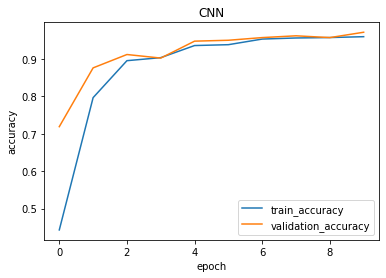

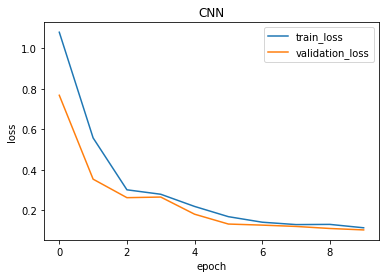

In [12]:
plot_accuracy(model,'CNN')
plot_loss(model,'CNN')

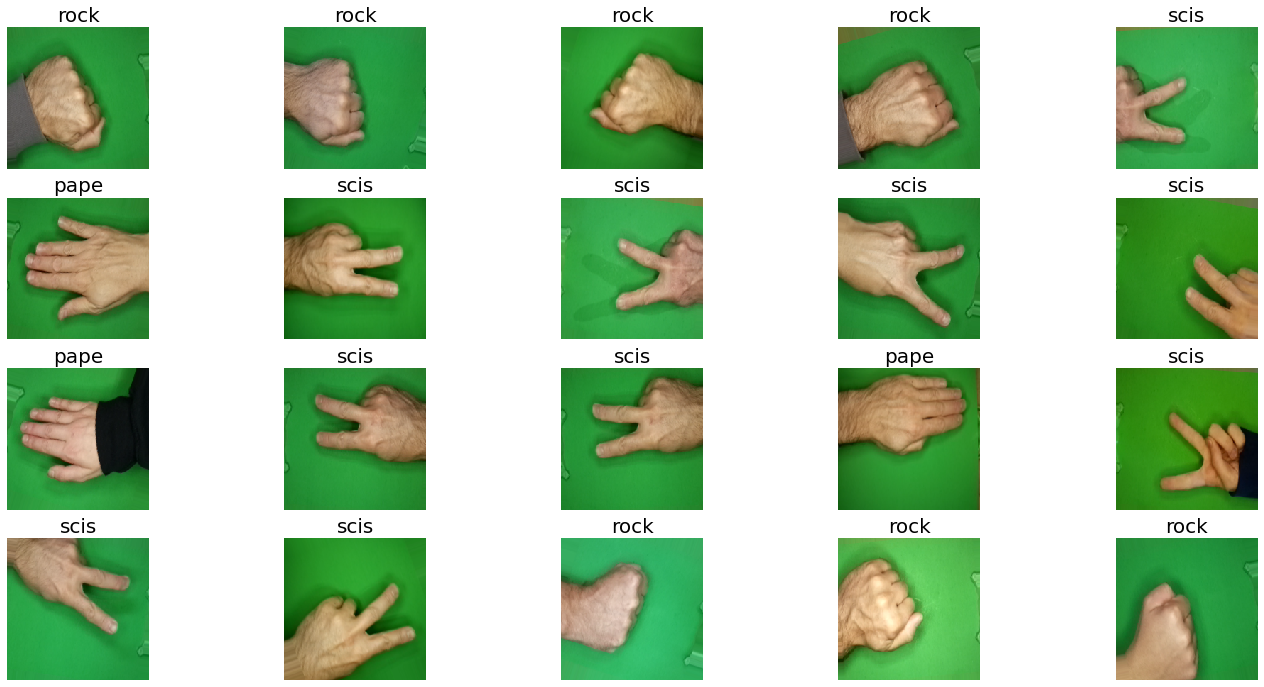

In [21]:
test_imgs, test_labels = next(test_generator)
predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = np.apply_along_axis(to_label, 1, test_labels)
df['predicted'] = np.apply_along_axis(to_label, 1, np.apply_along_axis(np.round, 1, predictions))
plots(test_imgs, titles=df['predicted'])

In [16]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
    # predicting images
    path = fn
    img = tf.keras.preprocessing.image.load_img(path, target_size=(200,200))
    imgplot = plt.imshow(img)
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    classes = model.predict(x, batch_size=10)
    print(np.apply_along_axis(to_label, 1, classes)[0])